In [21]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
warnings.filterwarnings("ignore")

In [22]:
cardio = pd.read_csv("cardio_train.csv",delimiter=";")

cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [23]:
cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


# 1 - Data Preprocessing and Exploratory Data Analysis <a class="anchor"  id="bir"></a>

In [24]:
num_entries = cardio.shape[0]*cardio.shape[1]
print('Number of entries in the dataframe: ', num_entries)

num_missing_values = cardio.isna().sum().sum()
print('Missing values: ', num_missing_values, '\n')

cardio_dup = cardio.duplicated().sum()
if cardio_dup:
    print('Duplicates Rows in Dataset are : {}'.format(cardio_dup))
else:
    print('Dataset contains no Duplicate Values')

Number of entries in the dataframe:  910000
Missing values:  0 

Dataset contains no Duplicate Values


In [25]:
cardio.drop_duplicates(inplace=True)

cardio.drop(['id'], axis=1,inplace=True)

In [26]:
cardio.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
cardio['age'] = cardio['age'].apply(lambda x: x/365)  

In [28]:
outliers = len(cardio[(cardio["ap_hi"]>=280) | (cardio["ap_lo"]>=220) | (cardio["ap_lo"] < 0) | (cardio["ap_hi"] < 0) | (cardio["ap_hi"]<cardio["ap_lo"])])

print(f'we have total {outliers} outliers')
print(f'percent missing: {round(outliers/len(cardio)*100,1)}%')

we have total 1275 outliers
percent missing: 1.8%


In [29]:
#Filtering out the unrealistic data of Systolic blood pressure and Diastolic blood pressure
cardio = cardio[ (cardio['ap_lo'] >= 0) & (cardio['ap_hi'] >= 0) ]  #remove negative values
cardio = cardio[ (cardio['ap_lo'] <= 220) & (cardio['ap_hi'] <= 280) ]  #remove fishy data points
cardio = cardio[ (cardio['ap_lo'] < cardio['ap_hi']) ]  #remove systolic higher than diastolic


In [30]:
Q1_hi = cardio['ap_hi'].quantile(0.05) # 5th percentile of the data of the given feature
Q3_hi = cardio['ap_hi'].quantile(0.95)  # 95th percentile of the data of the given feature
IQR_hi = Q3_hi - Q1_hi
lower, upper = Q1_hi - 1.5 * IQR_hi, Q3_hi + 1.5 * IQR_hi
cardio = cardio[(cardio['ap_hi'] >= lower) & (cardio['ap_hi'] <= upper)]  

Q1_lo = cardio['ap_lo'].quantile(0.05) # 5th percentile of the data of the given feature
Q3_lo = cardio['ap_lo'].quantile(0.95)  # 95th percentile of the data of the given feature
IQR_lo = Q3_lo - Q1_lo
lower, upper = Q1_lo - 1.5 * IQR_lo, Q3_lo + 1.5 * IQR_lo
cardio = cardio[(cardio['ap_lo'] >= lower) & (cardio['ap_lo'] <= upper)]  

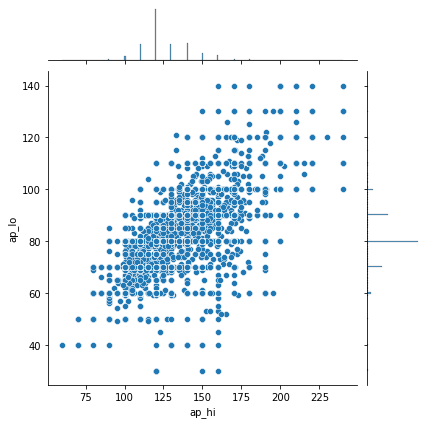

In [31]:
sns.jointplot(x='ap_hi', y='ap_lo', data=cardio);

<AxesSubplot:>

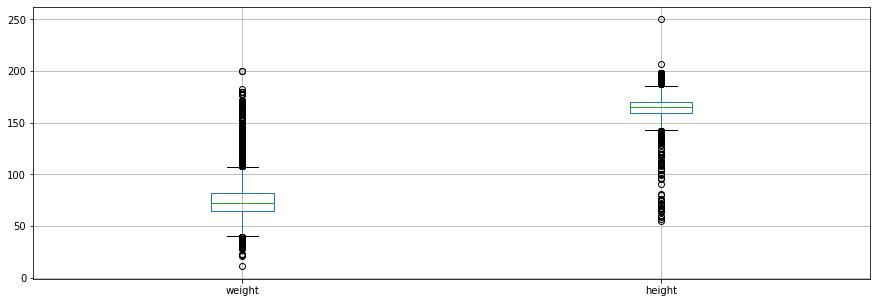

In [32]:
plt.figure(figsize=(15,5))
cardio.boxplot(['weight','height'])

In [33]:
#-------------------2.Variant------------------------------------------------
#Function that detects the outlier given interquartile range
def detect_outliers(df,q1,q3):
  for col in df.columns:
    df_feature = df[col]
    Q1 = df_feature.quantile(q1) # 25th percentile of the data of the given feature
    Q3 = df_feature.quantile(q3)  # 75th percentile of the data of the given feature
    IQR = Q3 - Q1    #IQR is interquartile range. 
    print(f'Feature: {col}-------------')
    print(f'Percentiles: {int(q1*100)}th={Q1}, {int(q3*100)}th={Q3}, IQR={IQR}')
    # calculate the outlier lower and upper bound
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    # identify outliers
    outliers = [x for x in df_feature if x < lower or x > upper]
    print('Identified outliers: %d \n' % len(outliers))

  
detect_outliers(cardio[['height', 'weight']],0.05,0.95)

Feature: height-------------
Percentiles: 5th=152.0, 95th=178.0, IQR=26.0
Identified outliers: 46 

Feature: weight-------------
Percentiles: 5th=55.0, 95th=100.0, IQR=45.0
Identified outliers: 20 



In [34]:
cardio_cleaned = cardio 
for col in ['height','weight']:
  Q1 = cardio[col].quantile(0.05) # 5th percentile of the data of the given feature
  Q3 = cardio[col].quantile(0.95)  # 95th percentile of the data of the given feature
  IQR = Q3 - Q1
  lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
  cardio_cleaned = cardio_cleaned[(cardio_cleaned[col] >= lower) & (cardio_cleaned[col] <= upper)]  


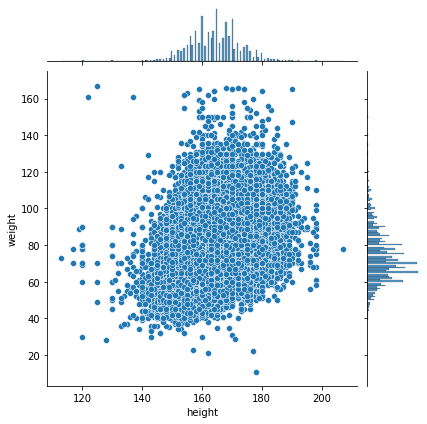

In [35]:
#To study the joint distribution of two numerical features, the jointplot of the Seaborn library can be useful:
sns.jointplot(x='height', y='weight', data=cardio_cleaned);

In [36]:
cardio_cleaned = cardio 
for col in ['height','weight']:
  Q1 = cardio[col].quantile(0.05) # 5th percentile of the data of the given feature
  Q3 = cardio[col].quantile(0.95)  # 95th percentile of the data of the given feature
  IQR = Q3 - Q1
  lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
  cardio_cleaned = cardio_cleaned[(cardio_cleaned[col] >= lower) & (cardio_cleaned[col] <= upper)]  

In [18]:
X = cardio_cleaned.drop(['cardio'], axis=1) 
y = cardio_cleaned['cardio']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)



print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (54886, 11)
X_test shape is  (13722, 11)
y_train shape is  (54886,)
y_test shape is  (13722,)


The accuracy score is: 0.7135986007870573
Sensitivity (TPR) = 0.6645466646945718

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      6961
           1       0.73      0.66      0.70      6761

    accuracy                           0.71     13722
   macro avg       0.72      0.71      0.71     13722
weighted avg       0.71      0.71      0.71     13722



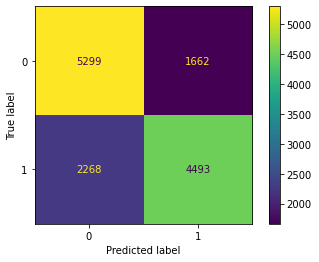

In [19]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


logreg_acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred) # Confusion matrix 
tpr_logreg = cm[1][1] /(cm[1][0] + cm[1][1])

print('The accuracy score is:', logreg_acc) # accuracy score
print('Sensitivity (TPR) =', tpr_logreg) 

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_pred ))

plot_confusion_matrix(logreg, X_test, y_test)
plt.show()

In [20]:
# Creating classifiers for every value of K
classifiers = []
nb_neighbor = [1, 5, 10, 20, 30, 40, 50]
for i in range(len(nb_neighbor)):
    classifiers.append(KNeighborsClassifier(nb_neighbor[i]))

# Initializing the lists for accuracy, true positive rate and true negative rate
# Later used to compare the classifiers for different values of K
score_list = []
true_positive = []
true_negative = []

# Fitting the training dataset for every classifier and calculating metrics

index = 0
for clf in classifiers: 
    clf.fit(X_train,y_train)

    score = clf.score(X_test, y_test)    
    y_pred = clf.predict(X_test)
    
    print(f"Accuracy for K =", nb_neighbor[index] ,"nearest Neighbors: ",  accuracy_score(y_test, y_pred))

    
    cm = confusion_matrix(y_test, y_pred) # Confusion matrix  

    score_list.append(score)
    true_positive.append(cm[1][1])
    true_negative.append(cm[0][0])
    
    index = index + 1




Accuracy for K = 1 nearest Neighbors:  0.6327794782101734
Accuracy for K = 5 nearest Neighbors:  0.6883107418743624
Accuracy for K = 10 nearest Neighbors:  0.7087888062964582
Accuracy for K = 20 nearest Neighbors:  0.7173881358402565
Accuracy for K = 30 nearest Neighbors:  0.7219064276344557
Accuracy for K = 40 nearest Neighbors:  0.7224894330272555
Accuracy for K = 50 nearest Neighbors:  0.7205946655006559
